<h2>Imports</h2>

In [1]:
import os
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import datetime as dt
import mplfinance as mpf

import time

<h2>Default Values</h2>

In [2]:
PATH="C:/Users/Zak/Documents/Programming/Data_Science/Finance/finance_course/Stock_list/"
import default_values

<h2>Get Stock File Names in a List</h2>

In [3]:
# listdir is going to return all files in the directory, if the thing listed is a file, then we'll store its name in a "files" list
files = [x for x in listdir(PATH) if isfile (join(PATH,x))]

# and now remove the ".csv" extenstion
tickers = [os.path.splitext(x)[0] for x in files]

<h2>Returns a Dataframe from a CSV</h2>

In [4]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv')
        df = df[::-1]
    except FileNotFoundError:
        print("File Doesn't exist")
    else:
        return df

<h2>Save Dataframe to CSV & Delete Unnamed Columns</h2>

In [5]:
def save_df_to_csv(df, ticker):
    df.to_csv(PATH + ticker + '.csv')
    
def delete_unnamed_cols(df):
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    return df

<h2>Return Valid Dates in Dataframe</h2>

Checks if the dates are good as far as if the stock market is open that day etc...

In [6]:
def get_valid_dates(df, sdate, edate):
    try:
        mask = (df['Date'] > sdate) & (df['Date'] <= edate)
        # create smaller dataframe that only gets the valid dates set by the mask
        sm_df = df.loc[mask]
        # set indices as dates
        sm_df = sm_df.set_index(['Date'])
        # get first and last dates of the date range
        first_date = sm_df.index.min()
        last_date = sm_df.index.max()
        
        # if the date has only one number (like 1-1-2021), then a '0' is added before
        date_leading = '-'.join( ('0' if len(x) < 2 else '') + x for x in first_date.split('-') )
        date_ending = '-'.join( ('0' if len(x) < 2 else '') + x for x in last_date.split('-') )
    except Exception:
        print("Date Corrupted")
    else:
        return date_leading, date_ending
        
        

<h2>ROI over time</h2>

In [7]:
def roi_between_dates(df, sdate, edate):
    try:
        # Gets the Adj Close price for 1st & last date 
        start_val = df.loc[sdate]['Adj Close'] 
        end_val = df.loc[edate]['Adj Close'] 
        roi = ((end_val - start_val) / start_val)
    except Exception:
        print("Data Corrupted")
    else:
        return roi

<h2>Mean between Dates</h2>

In [8]:
def get_mean_between_dates(df, sdate, edate):
    mask = (df['Date'] > sdate) & (df['Date'] <= edate)
    return df.loc[mask]['Adj Close'].mean()

<h2>Standard Deviation between dates</h2>

In [9]:
def get_sd_between_dates(df, sdate, edate):
    mask = (df['Date'] > sdate) & (df['Date'] <= edate)
    return df.loc[mask]['Adj Close'].std()

<h2>Covariance</h2>

In [10]:
def get_cov_between_dates(df, sdate, edate):
    return (get_sd_between_dates(df,sdate,edate) / get_mean_between_dates(df,sdate,edate))

<h2>Test Functions</h2>

In [11]:
print("=========================")
print("Testing for : ", tickers[0])
print("=========================")

stock_a = get_df_from_csv(tickers[0])

print(get_valid_dates(stock_a,'2020-01-01','2020-12-31'))
sdate, edate = get_valid_dates(stock_a,'2020-01-01','2020-12-31')
print("Ajd Close Mean: ", get_mean_between_dates(stock_a, sdate, edate))
print("Ajd Close Standard Deviation: ", get_sd_between_dates(stock_a, sdate, edate))
print("Ajd Close Covariance: ", get_cov_between_dates(stock_a, sdate, edate))
stock_a = stock_a.set_index(['Date'])
print("ROI: ", roi_between_dates(stock_a, sdate, edate))
print("=========================")
print()

print("=========================")
print("Testing for CSCO")
print("=========================")
stock_b = get_df_from_csv('CSCO')
sdate, edate = get_valid_dates(stock_b,'2020-01-01','2020-12-31')
print("Ajd Close Mean: ", get_mean_between_dates(stock_b, sdate, edate))
print("Ajd Close Standard Deviation: ", get_sd_between_dates(stock_b, sdate, edate))
print("Ajd Close Covariance: ", get_cov_between_dates(stock_b, sdate, edate))
stock_b = stock_b.set_index(['Date'])
print("ROI: ", roi_between_dates(stock_b, sdate, edate))
print("=========================")



Testing for :  AA
('2020-01-02', '2020-12-31')
Ajd Close Mean:  13.356706361922006
Ajd Close Standard Deviation:  4.545523786027696
Ajd Close Covariance:  0.3403177147763248
ROI:  0.07609706605792996

Testing for CSCO
Ajd Close Mean:  41.57403742320954
Ajd Close Standard Deviation:  3.446306017645834
Ajd Close Covariance:  0.08289562985099601
ROI:  -0.05100995551625191


<h2>COV & ROI for all stocks over a defined period</h2>

In [12]:
def get_cov_roi(tickers, sdate, edate):
    col_names = ["Ticker", "COV", "ROI"]
    df = pd.DataFrame(columns= col_names)
    for ticker in tickers:
        # print("Working on : ", ticker)
        s_df = get_df_from_csv(ticker)
        sdate2, edate2 = get_valid_dates(s_df, sdate, edate)
        cov = get_cov_between_dates(s_df, sdate2, edate2)
        s_df = s_df.set_index(['Date'])
        roi = roi_between_dates(s_df, sdate2, edate2)
        df.loc[len(df.index)] = [ticker, cov, roi]
    return df

In [13]:
market_df = get_cov_roi(tickers, '2019-01-01', '2019-12-31')
market_df

,Ticker,COV,ROI
0,AA,0.158993,-0.180259
1,AAL,0.094255,-0.106021
2,AAME,0.123107,-0.202506
3,AAOI,0.202465,-0.251889
4,AAON,0.096021,0.418350
...,...,...,...
2901,ZSAN,0.372906,-0.350427
2902,ZTS,0.129821,0.576627
2903,ZUMZ,0.146251,0.760448
2904,ZYNE,0.376312,0.623656


In [14]:
print("Best 20 Stocks based on ROI")
market_df.sort_values(by=['ROI'], ascending = False).head(20)

Best 20 Stocks based on ROI


,Ticker,COV,ROI
286,AXSM,0.745206,37.567163
791,DRRX,0.566453,6.037037
1622,MBOT,0.290907,4.438503
866,ENPH,0.447633,4.310975
1908,OESX,0.402282,4.000000
220,ARWR,0.496426,3.834604
2806,WKHS,0.526715,3.676923
2238,ROKU,0.374797,3.117466
1689,MLSS,0.570364,3.088235
1521,LEU,0.346334,3.047059


<h2></h2>

<h2>Merge multiple Stocks in One Dataframe by Column name</h2>

In [15]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv(x)
        print("Working on : ", x)
        df['Date'] = pd.to_datetime(df['Date'])
        # Use a mask to grab data between defined dates
        mask = (df['Date'] >= sdate) & (df['Date'] <= edate)
        print("colname",col_name)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

<h2>Create a Correlation Matrix using FAANGS</h2>

@TODO fix with AAPL and AMZN

In [23]:
faang_list = ["FB", "NFLX", "GOOG", "MSFT"]#,"AAPL","AMZN"]
mult_df = merge_df_by_column_name('daily_return',  '2020-1-1', '2020-12-31', *faang_list)
mult_df.corr()

Working on :  FB
colname daily_return
Working on :  NFLX
colname daily_return
Working on :  GOOG
colname daily_return
Working on :  MSFT
colname daily_return


,FB,NFLX,GOOG,MSFT
FB,1.000000,0.595254,0.810791,0.776997
NFLX,0.595254,1.000000,0.546265,0.617632
GOOG,0.810791,0.546265,1.000000,0.859815
MSFT,0.776997,0.617632,0.859815,1.000000


<Axes: >

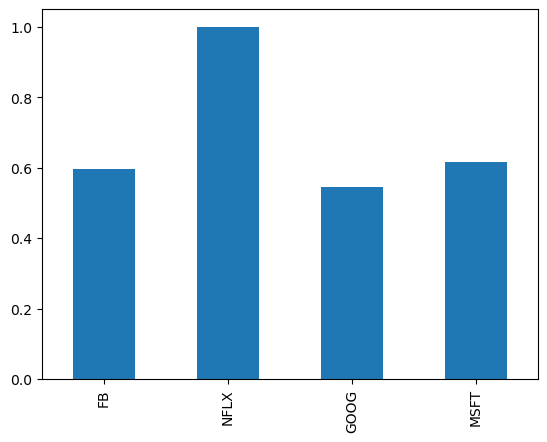

In [24]:
mult_df.corr()['NFLX'].plot(kind='bar')

<h2>Get the variance of a stock</h2>

In [18]:
print("Variance: ", mult_df['NFLX'].var())
# in an annualized form
days = len(mult_df.index)
print("Annualized Variance : ", mult_df['NFLX'].var() * days)

Variance:  0.0008542915350884244
Annualized Variance :  0.21613575837737137


<h2>Get Covariance of Stocks</h2>

In [19]:
mult_df.cov() * 253

,FB,NFLX,GOOG,MSFT
FB,0.215868,0.128576,0.145724,0.160259
NFLX,0.128576,0.216136,0.098242,0.127468
GOOG,0.145724,0.098242,0.149644,0.147653
MSFT,0.160259,0.127468,0.147653,0.197069


<h2>Calculating a Portfolio's Variance</h2>

When calculating the variance of a portfolio, one must establish its weight

$w_1,w_2$ = Stock Weights

$\sigma_1,\sigma_1$ = Stock standard deviations

Portfolio Variance = $(w_1\sigma_1 + w_2\sigma_2)^{2}$

since $(a+b)^{2} = a^{2} + 2ab+ b^{2}$

then the portfolio variance is $w_1^{2}\sigma_1^{2} + 2w_1\sigma_1w_2\sigma_2\rho_{1,2} + w_2^{2}\sigma_2^{2}$

In [20]:
port_list = ["FB","NEM"]
port_df = merge_df_by_column_name('daily_return','2020-1-1','2020-12-31',*port_list)

port_df

port_df.corr()

Working on :  FB
colname daily_return
Working on :  NEM
colname daily_return


,FB,NEM
FB,1.000000,0.186682
NEM,0.186682,1.000000


In [21]:
price_df = merge_df_by_column_name('Adj Close','2020-1-1','2020-12-31',*port_list)
price_df.head()

# weight = value of holding over value of all holdings
# one share of FB
fb_wt = 209.78 / 418.48
# 5 shares of WEM
new_wt = 208.70 / 418048

fb_wt = 0.5012
nem_wt = 0.4988
wts = np.array([fb_wt,nem_wt])
# transpose matrix
port_var = np.dot(wts.T, np.dot(port_df.cov() * 253, wts))
print("Portfolio Variance : ", port_var)
print("FB Variance : ", port_df['FB'].var()*253)
print("NEM Variance : ", port_df['NEM'].var()*253)

Working on :  FB
colname Adj Close
Working on :  NEM
colname Adj Close
Portfolio Variance :  0.12685748050948573
FB Variance :  0.21586759061066657
NEM Variance :  0.2117209133919327


<h2>All Sectors</h2>

@TODO Get TEXT LATER

<h2>Get Sector Stocks</h2>

In [26]:
sec_df = pd.read_csv("C:/Users/Zak/Documents/Programming/Data_Science/Finance/finance_course/stock_sectors/stock_sectors.csv")
sec_df

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care
503,ZION,Zions Bancorp,Financials


In [28]:
indus_df = sec_df.loc[sec_df['Sector'] == 'Industrials']
health_df = sec_df.loc[sec_df['Sector'] == "Health Care"]
it_df = sec_df.loc[sec_df['Sector'] == "Information Technology"]
comm_df = sec_df.loc[sec_df['Sector'] == "Communication Services"]
staple_df = sec_df.loc[sec_df['Sector'] == "Consumer Staples"]
discretion_df = sec_df.loc[sec_df['Sector'] == "Consumer Discretionary"]
utility_df = sec_df.loc[sec_df['Sector'] == "Utilities"]
financial_df = sec_df.loc[sec_df['Sector'] == "Financials"]
material_df = sec_df.loc[sec_df['Sector'] == "Materials"]
restate_df = sec_df.loc[sec_df['Sector'] == "Real Estate"]
energy_df = sec_df.loc[sec_df['Sector'] == "Energy"]

<h2>Return a DataFrame with en ROI for all stocks</h2>

In [44]:
def get_rois_for_stocks(stocks_df, sdate, edate):
    tickers = []
    rois = []
    for index, row in stocks_df.iterrows():
        df = get_df_from_csv(row['Symbol'])
        # check if the tickers exists for that specific DF
        if df is None:
            pass
        else:
            tickers.append(row['Symbol'])
            # TODO remove dates from hardcoding and include in the function parameters
            sdatef, edatef = get_valid_dates(df, sdate, edate)
            df = df.set_index(['Date'])
            roi = roi_between_dates(df, sdatef, edatef)
            rois.append(roi)
            
    return pd.DataFrame({'Ticker': tickers, 'ROI': rois})

In [ ]:
industrial = get_rois_for_stocks(indus_df, '2018-01-01', '2020-12-31')
health_care = get_rois_for_stocks(health_df, '2018-01-01', '2020-12-31')
it = get_rois_for_stocks(it_df, '2018-01-01', '2020-12-31')
commun = get_rois_for_stocks(comm_df, '2018-01-01', '2020-12-31')
staple = get_rois_for_stocks(staple_df, '2018-01-01', '2020-12-31')
discretion = get_rois_for_stocks(discretion_df, '2018-01-01', '2020-12-31')
utility = get_rois_for_stocks(utility_df, '2018-01-01', '2020-12-31')
finance = get_rois_for_stocks(financial_df, '2018-01-01', '2020-12-31')
material = get_rois_for_stocks(material_df, '2018-01-01', '2020-12-31')
restate = get_rois_for_stocks(restate_df, '2018-01-01', '2020-12-31')
energy = get_rois_for_stocks(energy_df, '2018-01-01', '2020-12-31')

File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist
File Doesn't exist


<h2>Top Industrials</h2>

In [48]:
industrial.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
24,GNRC,3.734749
10,CPRT,1.918578
57,TDG,1.518984
9,CTAS,1.325593
42,ODFL,1.202971


<h2>Top Healthcare</h2>

In [49]:
health_care.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
24,DXCM,5.375582
32,IDXX,2.167543
58,WST,1.887307
48,RMD,1.575014
15,CTLT,1.475499


<h2>Top Information Technologies</h2>

In [50]:
it.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
21,ENPH,66.488464
2,AMD,7.352459
50,PAYC,4.622203
57,NOW,3.178471
70,ZBRA,2.705814


<h2>Top Communications</h2>

In [51]:
commun.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
13,NFLX,1.689262
20,TWTR,1.209302
17,TMUS,1.105715
4,CHTR,0.895722
18,TTWO,0.840804


<h2>Top Staples</h2>

In [52]:
staple.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
10,EL,1.145196
9,COST,1.112863
19,MKC,0.977708
3,CHD,0.838448
25,PG,0.674050


<h2>Top Discretionary</h2>

In [53]:
discretion.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
52,TSLA,10.007861
17,ETSY,7.541047
10,CMG,3.733606
43,POOL,1.931030
51,TGT,1.839621


<h2>Top Utilities</h2>

In [55]:
utility.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
0,AES,1.402997
18,NEE,1.136332
4,AWK,0.819223
26,WEC,0.530405
27,XEL,0.519897


<h2>Top Finance</h2>

In [56]:
finance.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
39,MSCI,2.612068
34,MKTX,1.860333
6,AJG,1.112315
37,MCO,1.044882
49,SPGI,1.012123


<h2>Top Materials</h2>

In [57]:
material.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
3,BLL,1.474668
21,SHW,0.824243
13,LIN,0.785525
0,APD,0.771644
16,NEM,0.689577


<h2>Top Real Estate</h2>

In [58]:
restate.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
21,SBAC,0.772695
8,EQIX,0.692928
17,PLD,0.689758
1,AMT,0.685782
5,CCI,0.622156


<h2>Top Energy</h2>

In [59]:
energy.sort_values(by=['ROI'], ascending = False).head(5)

,Ticker,ROI
9,HES,0.168441
15,OKE,-0.131482
10,KMI,-0.146362
3,COP,-0.217487
20,WMB,-0.218709


<h2>Portfolio List</h2>

In [60]:
port_list = ["GNRC", "DXCM", "AMD", "NFLX", "COST", "TGT", "AES", "MSCI", "NEM", "SBAC", "HES"]

<h2>Check for Correlation</h2>

In [61]:
mult_df = merge_df_by_column_name('daily_return',  '2018-01-01', 
                                  '2020-12-31', *port_list)
mult_df

# Generate a Correlation Matrix
mult_df.corr()

Working on :  GNRC
colname daily_return
Working on :  DXCM
colname daily_return
Working on :  AMD
colname daily_return
Working on :  NFLX
colname daily_return
Working on :  COST
colname daily_return
Working on :  TGT
colname daily_return
Working on :  AES
colname daily_return
Working on :  MSCI
colname daily_return
Working on :  NEM
colname daily_return
Working on :  SBAC
colname daily_return
Working on :  HES
colname daily_return


,GNRC,DXCM,AMD,NFLX,COST,TGT,AES,MSCI,NEM,SBAC,HES
GNRC,1.000000,0.312744,0.006354,0.355091,-0.003880,0.348460,-0.030453,0.524121,0.241925,0.444372,0.434646
DXCM,0.312744,1.000000,0.021128,0.335028,-0.008217,0.211187,-0.053733,0.491442,0.147457,0.268902,0.245543
AMD,0.006354,0.021128,1.000000,0.033529,0.390858,-0.060256,0.278423,0.026684,-0.017285,-0.087626,-0.035707
NFLX,0.355091,0.335028,0.033529,1.000000,-0.049751,0.271594,-0.006544,0.464810,0.096992,0.225670,0.232714
COST,-0.003880,-0.008217,0.390858,-0.049751,1.000000,-0.028066,0.337863,-0.011892,0.015636,-0.020376,-0.005489
TGT,0.348460,0.211187,-0.060256,0.271594,-0.028066,1.000000,-0.093797,0.328986,0.088937,0.311312,0.241815
AES,-0.030453,-0.053733,0.278423,-0.006544,0.337863,-0.093797,1.000000,-0.045311,0.006541,0.005654,-0.046339
MSCI,0.524121,0.491442,0.026684,0.464810,-0.011892,0.328986,-0.045311,1.000000,0.246352,0.492733,0.412224
NEM,0.241925,0.147457,-0.017285,0.096992,0.015636,0.088937,0.006541,0.246352,1.000000,0.261938,0.164185
SBAC,0.444372,0.268902,-0.087626,0.225670,-0.020376,0.311312,0.005654,0.492733,0.261938,1.000000,0.277106


<h2>Number of samples</h2>

In [62]:
# Get the number of samples
days = len(mult_df.index)
days

756

<h2>Stock Price on a given Date</h2>

In [63]:
def get_stock_price_on_date(ticker, date):
    df = get_df_from_csv(ticker)
    df = df.set_index(['Date'])
    return df.loc[date,'Adj Close']

In [64]:
# 01-04-2021 is the 1st date in 2021
print("GNRC $", get_stock_price_on_date('GNRC', '2021-01-04')) # 2 449.12
print("DXCM $", get_stock_price_on_date('DXCM', '2021-01-04')) # 1 357.74
print("AMD $", get_stock_price_on_date('AMD', '2021-01-04')) # 4 369.2
print("NFLX $", get_stock_price_on_date('NFLX', '2021-01-04')) # 1 522.86
print("COST $", get_stock_price_on_date('COST', '2021-01-04')) # 1 377.88
print("TGT $", get_stock_price_on_date('TGT', '2021-01-04')) # 3 527.46
print("AES $", get_stock_price_on_date('AES', '2021-01-04')) # 18 410.76
print("MSCI $", get_stock_price_on_date('MSCI', '2021-01-04')) # 1 435.40
print("NEM $", get_stock_price_on_date('NEM', '2021-01-04')) # 7 434.49
print("SBAC $", get_stock_price_on_date('SBAC', '2021-01-04')) # 2 548.84
print("HES $", get_stock_price_on_date('HES', '2021-01-04')) # 9 472.23

# Total Investment
tot_inv = 449.12 + 357.74 + 369.2 + 522.86 + 377.88 + 527.46 + 410.76 + \
435.40 + 434.49 + 548.84 + 472.23
tot_inv

GNRC $ 224.5599975585937
DXCM $ 357.739990234375
AMD $ 92.3000030517578
NFLX $ 522.8599853515625
COST $ 377.8815307617188
TGT $ 175.82254028320312
AES $ 22.82006454467773
MSCI $ 435.3967590332031
NEM $ 62.0733871459961
SBAC $ 274.4242248535156
HES $ 52.46865844726562


4905.980000000001

<h2>Get Portfolio Weight</h2>

In [65]:
def get_port_weight(price, total):
    return (price/total)

In [66]:
gnrc_w = get_port_weight(449.12, 4905.98)
dxcm_w = get_port_weight(357.74, 4905.98)
amd_w = get_port_weight(369.2, 4905.98)
nflx_w = get_port_weight(522.86, 4905.98)
cost_w = get_port_weight(377.88, 4905.98)
tgt_w = get_port_weight(527.46, 4905.98)
aes_w = get_port_weight(410.76, 4905.98)
msci_w = get_port_weight(435.40, 4905.98)
nem_w = get_port_weight(434.49, 4905.98)
sbac_w = get_port_weight(548.84, 4905.98)
hes_w = get_port_weight(472.23, 4905.98)

In [67]:
wts = np.array([gnrc_w, dxcm_w, amd_w, nflx_w, cost_w, tgt_w, aes_w, msci_w, \
                nem_w, sbac_w, hes_w])
wts

array([0.09154542, 0.07291917, 0.0752551 , 0.10657606, 0.07702437,
       0.10751369, 0.08372639, 0.08874883, 0.08856335, 0.11187163,
       0.096256  ])

In [68]:
port_var = np.dot(wts.T, np.dot(mult_df.cov() * 756, wts))
print("Portfolio Covariance :", port_var)
print("GNRC Var :", mult_df["GNRC"].var() * 756)
print("NFLX Var :", mult_df["NFLX"].var() * 756)

Portfolio Covariance : 0.12222241483582241
GNRC Var : 0.4432566252339934
NFLX Var : 0.5490187771505236


<h2>Different types of Risk</h2>

<h3>Diversifiable Risk --> Idiosyncratic</h3>

In [69]:
# Diversifiable Risk = Portfolio Variance - All Weighted Variances
def calc_diversifiable_risk(df, tickers, weights):
    # Gets number of days
    days = len(mult_df.index)
    # Calculate covariance of portfolio
    port_covar = np.dot(weights.T, np.dot(df.cov() * days, weights)) 
    
    i = 0
    while i < len(tickers):
        wt_sq = weights[i] ** 2
        stk_var = mult_df[tickers[i]].var() * days
        wt_var = wt_sq * stk_var
        port_covar = port_covar - wt_var
        i += 1
    return port_covar

In [70]:
div_risk = calc_diversifiable_risk(mult_df, port_list, wts)
div_risk

0.07503503454469351

<h3>Undiversifiable Risk --> Systemic</h3>

In [71]:
print("Systematic Risk :", (port_var - div_risk))

Systematic Risk : 0.0471873802911289
